                   0          1
Intercept -10.416762  60.942135
WT         -4.147683   3.886654
VOL        -1.486618   1.209049
HP         -0.323055  -0.136010
SP          0.062873   0.823838


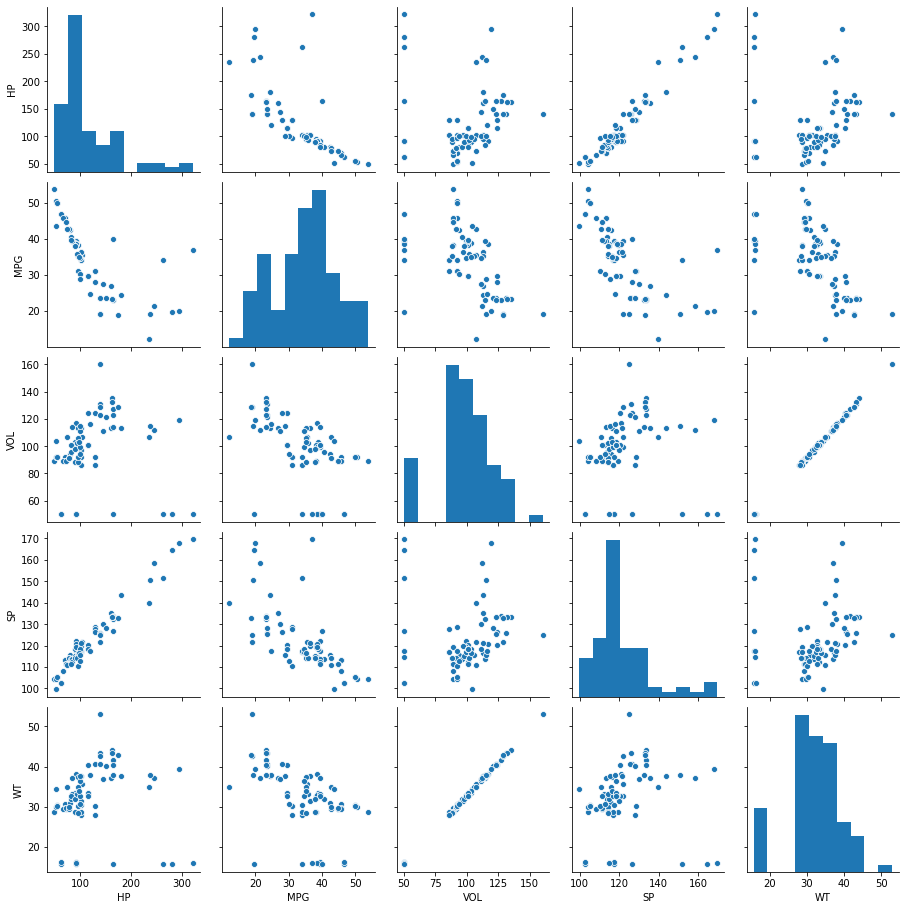

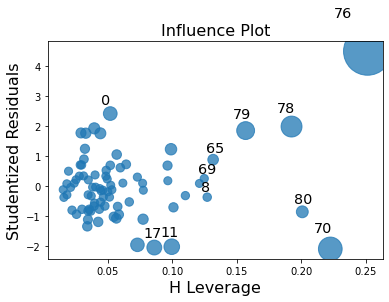

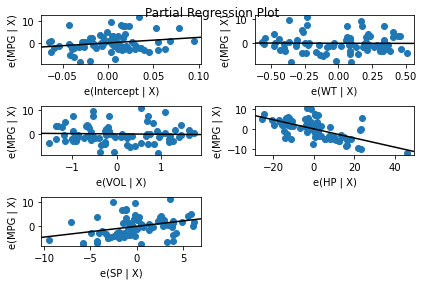

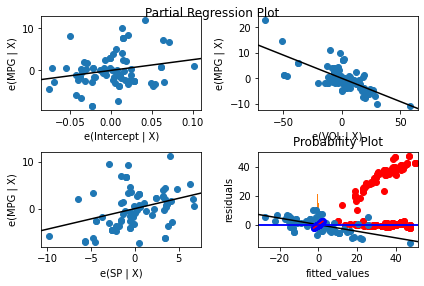

In [1]:
# Multilinear Regression
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# loading the data
cars = pd.read_csv("cars.csv")

# to get top 6 rows
cars.head(40) # to get top n rows use cars.head(10)

# Correlation matrix 
cars.corr()

# we see there exists High collinearity between input variables especially between
# [Hp & SP] , [VOL,WT] so there exists collinearity problem
 
# Scatter plot between the variables along with histograms
import seaborn as sns
sns.pairplot(cars)


# columns names
cars.columns

# pd.tools.plotting.scatter_matrix(cars); -> also used for plotting all in one graph
                             
# preparing model considering all the variables 
import statsmodels.formula.api as smf # for regression model
         
# Preparing model                  
ml1 = smf.ols('MPG~WT+VOL+SP+HP',data=cars).fit() # regression model

# Getting coefficients of variables               
ml1.params

# Summary
ml1.summary()
# p-values for WT,VOL are more than 0.05 and also we know that [WT,VOL] has high correlation value 

# preparing model based only on Volume
ml_v=smf.ols('MPG~VOL',data = cars).fit()  
ml_v.summary() # 0.271
# p-value <0.05 .. It is significant 

# Preparing model based only on WT
ml_w=smf.ols('MPG~WT',data = cars).fit()  
ml_w.summary() # 0.268

# Preparing model based only on WT & VOL
ml_wv=smf.ols('MPG~WT+VOL',data = cars).fit()  
ml_wv.summary() # 0.264
# Both coefficients p-value became insignificant... 
# So there may be a chance of considering only one among VOL & WT

# Checking whether data has any influential values 
# influence index plots

import statsmodels.api as sm
sm.graphics.influence_plot(ml1)
# index 76 AND 78 is showing high influence so we can exclude that entire row

# Studentized Residuals = Residual/standard deviation of residuals

cars_new=cars.drop(cars.index[[76,70]],axis=0)

#cars.drop(["MPG"],axis=1)

# X => A B C D 
# X.drop(["A","B"],axis=1) # Dropping columns 
# X.drop(X.index[[5,9,19]],axis=0)

#X.drop(["X1","X2"],aixs=1)
#X.drop(X.index[[0,2,3]],axis=0)


# Preparing model                  
ml_new = smf.ols('MPG~WT+VOL+HP+SP',data = cars_new).fit()    

# Getting coefficients of variables        
ml_new.params

# Summary
ml_new.summary() # 0.806

# Confidence values 99%
print(ml_new.conf_int(0.01)) # 99% confidence level


# Predicted values of MPG 
mpg_pred = ml_new.predict(cars_new[['WT','VOL','HP','SP']])
mpg_pred

cars_new.head()
# calculating VIF's values of independent variables
rsq_hp = smf.ols('HP~WT+VOL+SP',data=cars_new).fit().rsquared  
vif_hp = 1/(1-rsq_hp) # 16.33

rsq_wt = smf.ols('WT~HP+VOL+SP',data=cars_new).fit().rsquared  
vif_wt = 1/(1-rsq_wt) # 564.98

rsq_vol = smf.ols('VOL~WT+SP+HP',data=cars_new).fit().rsquared  
vif_vol = 1/(1-rsq_vol) #  564.84

rsq_sp = smf.ols('SP~WT+VOL+HP',data=cars_new).fit().rsquared  
vif_sp = 1/(1-rsq_sp) #  16.35

           # Storing vif values in a data frame
d1 = {'Variables':['Hp','WT','VOL','SP'],'VIF':[vif_hp,vif_wt,vif_vol,vif_sp]}
Vif_frame = pd.DataFrame(d1)  
Vif_frame
# As weight is having higher VIF value, we are not going to include this prediction model

# Added varible plot 
sm.graphics.plot_partregress_grid(ml_new)

# added varible plot for weight is not showing any significance 

# final model
final_ml= smf.ols('MPG~VOL+SP+HP',data = cars_new).fit()
final_ml.params
final_ml.summary() # 0.809
# As we can see that r-squared value has increased from 0.810 to 0.812.

mpg_pred = final_ml.predict(cars_new)

import statsmodels.api as sm
# added variable plot for the final model
sm.graphics.plot_partregress_grid(final_ml)


######  Linearity #########
# Observed values VS Fitted values
plt.scatter(cars_new.MPG,mpg_pred,c="r");plt.xlabel("observed_values");plt.ylabel("fitted_values")

# Residuals VS Fitted Values 
plt.scatter(mpg_pred,final_ml.resid_pearson,c="r"),plt.axhline(y=0,color='blue');plt.xlabel("fitted_values");plt.ylabel("residuals")


########    Normality plot for residuals ######
# histogram
plt.hist(final_ml.resid_pearson) # Checking the standardized residuals are normally distributed

# QQ plot for residuals 
import pylab          
import scipy.stats as st

# Checking Residuals are normally distributed
st.probplot(final_ml.resid_pearson, dist="norm", plot=pylab)


############ Homoscedasticity #######

# Residuals VS Fitted Values 
plt.scatter(mpg_pred,final_ml.resid_pearson,c="r"),plt.axhline(y=0,color='blue');plt.xlabel("fitted_values");plt.ylabel("residuals")



### Splitting the data into train and test data 

from sklearn.model_selection import train_test_split
cars_train,cars_test  = train_test_split(cars_new,test_size = 0.2) # 20% size

# preparing the model on train data 

model_train = smf.ols("MPG~HP+SP+VOL",data=cars_train).fit()

# train_data prediction
train_pred = model_train.predict(cars_train)

# train residual values 
train_resid  = train_pred - cars_train.MPG

# RMSE value for train data 
train_rmse = np.sqrt(np.mean(train_resid*train_resid))

# prediction on test data set 
test_pred = model_train.predict(cars_test)

# test residual values 
test_resid  = test_pred - cars_test.MPG

# RMSE value for test data 
test_rmse = np.sqrt(np.mean(test_resid*test_resid))
